In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import arch

from pmdarima import auto_arima
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA

## 1. Importing Data

In [2]:
# Importing Data
bit_data = yf.download(tickers = 'BTC-USD', start = "2020-04-01", end = "2021-01-01", interval = '1d')
gld_data = yf.download(tickers = 'GLD', start = "2020-04-01", end = "2021-01-01", interval = '1d')
vgk_data = yf.download(tickers = 'VGK', start = "2020-04-01", end = "2021-01-01", interval = '1d')

# Concatenating the adjusted close prices together
adj_close_data = pd.DataFrame(columns = ['BTC', 'GLD', 'VGK'])
adj_close_data['BTC'] = bit_data['Adj Close']
adj_close_data['GLD'] = gld_data['Adj Close']
adj_close_data['VGK'] = vgk_data['Adj Close']

# Filling NaN Values with forward-filling
adj_close_data.fillna(method = "ffill", axis = 0, inplace = True)

adj_close_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC,GLD,VGK
Date,,,
2020-03-31,6438.644531,148.050003,41.333157
2020-04-01,6606.776367,149.449997,39.518627
2020-04-02,6793.624512,151.899994,40.273087
2020-04-03,6733.387207,152.649994,39.432671
2020-04-04,6867.527344,152.649994,39.432671
...,...,...,...
2020-12-27,26272.294922,176.350006,58.935150
2020-12-28,27084.808594,175.710007,59.336601
2020-12-29,27362.437500,176.350006,59.767429


## 2. Data Processing and Calculating Returns

In [3]:
ret_data = pd.DataFrame(columns = ['BTC', 'GLD', 'VGK'])

# Calculating daily returns for GOLD ETF
ret_data['BTC'] = np.log(adj_close_data['BTC']) - np.log(adj_close_data['BTC'].shift(1))

# Calculating daily returns for GOLD ETF
ret_data['GLD'] = np.log(adj_close_data['GLD']) - np.log(adj_close_data['GLD'].shift(1))

# Calculating daily returns for EQUITY ETF
ret_data['VGK'] = np.log(adj_close_data['VGK']) - np.log(adj_close_data['VGK'].shift(1))

ret_data.dropna(inplace = True)
ret_data

,BTC,GLD,VGK
Date,,,
2020-04-01,0.025778,0.009412,-0.044893
2020-04-02,0.027889,0.016261,0.018911
2020-04-03,-0.008906,0.004925,-0.021089
2020-04-04,0.019726,0.000000,0.000000
2020-04-05,-0.011187,0.000000,0.000000
...,...,...,...
2020-12-27,-0.006251,0.000000,0.000000
2020-12-28,0.030458,-0.003636,0.006789
2020-12-29,0.010198,0.003636,0.007235


## 3. Data Summaries Extreme Values

Here we use the Z Score method for finding the extreme values, meaning that when a values is 3 standard deviations away from the mean of our data series we consider that an extreme, probably rare, realization of the data generating process.

In [4]:
# 3.1 Calculating total returns of assets for the given period
btc_tot_ret = ret_data['BTC'].sum()
gld_tot_ret = ret_data['GLD'].sum()
vgk_tot_ret = ret_data['VGK'].sum()

print("Bitcoin's return for the given period is: {} %".format(np.round(btc_tot_ret*100, 3)))
print("Gold ETF's return for the given period is: {} %".format(np.round(gld_tot_ret*100, 3)))
print("Equity ETF's return for the given period is: {} %".format(np.round(vgk_tot_ret*100, 3)))
print("")

# 3.2 Computing the kurtosis of each return series 
btc_kurt = ret_data['BTC'].kurtosis()
gld_kurt = ret_data['GLD'].kurtosis()
vgk_kurt = ret_data['VGK'].kurtosis()

print("Bitcoin's kurtosis for the given period is: {}".format(btc_kurt))
print("Gold ETF's kurtosis for the given period is: {}".format(gld_kurt))
print("Equity ETF's kurtosis for the given period is: {}".format(vgk_kurt))
print("")

# 3.3 - 3.4 Using z-score method for finding extreme values

# BTC 
btc_high_bound =  ret_data['BTC'].mean() + 3*ret_data['BTC'].std()
btc_low_bound  =  ret_data['BTC'].mean() - 3*ret_data['BTC'].std()
btc_outliers = ret_data['BTC'][(ret_data['BTC'] >= btc_high_bound) | (ret_data['BTC'] <= btc_low_bound)]
print("BTC outlier returns are: ")
print(btc_outliers*100)

# GLD 
gld_high_bound =  ret_data['GLD'].mean() + 3*ret_data['GLD'].std()
gld_low_bound  =  ret_data['GLD'].mean() - 3*ret_data['GLD'].std()
gld_outliers = ret_data['GLD'][(ret_data['GLD'] >= gld_high_bound) | (ret_data['GLD'] <= gld_low_bound)]
print("GLD outlier returns are: ")
print(gld_outliers*100)

# VGK 
vgk_high_bound =  ret_data['VGK'].mean() + 3*ret_data['VGK'].std()
vgk_low_bound  =  ret_data['VGK'].mean() - 3*ret_data['VGK'].std()
vgk_outliers = ret_data['VGK'][(ret_data['VGK'] >= vgk_high_bound) | (ret_data['VGK'] <= vgk_low_bound)]
print("VGK outlier returns are: ")
print(vgk_outliers*100)

Bitcoin's return for the given period is: 150.504 %
Gold ETF's return for the given period is: 18.625 %
Equity ETF's return for the given period is: 35.56 %

Bitcoin's kurtosis for the given period is: 2.742976185262016
Gold ETF's kurtosis for the given period is: 7.800406418235283
Equity ETF's kurtosis for the given period is: 4.094622622923568

BTC outlier returns are: 
Date
2020-04-29    11.984141
2020-05-10    -9.133875
2020-07-27    10.400867
2020-09-03   -10.802491
2020-11-05     9.741581
2020-11-26    -8.820525
Name: BTC, dtype: float64
GLD outlier returns are: 
Date
2020-08-11   -5.518973
2020-08-19   -3.207438
2020-11-09   -4.528086
Name: GLD, dtype: float64
VGK outlier returns are: 
Date
2020-04-01   -4.489287
2020-04-06    4.822496
2020-04-15   -4.173817
2020-05-18    4.420707
2020-06-11   -6.042103
2020-10-28   -3.935251
Name: VGK, dtype: float64


### [ THE SECTION'S TITLE]


--- EXPLAIN THE THEORY BEHIND YOUR IMPLEMENTATION HERE (IF NEEDED) ---
#### Header One 

#### Header Two

In [5]:
# USE HASHTAGS TO DIVIDE YOUR CODE INTO READABLE CHUNKS OR YOU CAN ADDRESS EACH PROMPT SEPERATELY
# 4.1 (EXAMPLE)






##### Interpretation of the Results

--- COMMENT ON YOUR RESULTS ---

## 4. Data Comparison Copulas

#### 4.1 Pick 2 of the series  that had the most extreme values.
Here, we chose the VGK ETF and Bitcoin given that they had the most extreme values.

In [6]:
# Utility methods to calculate the returns of a provided quarter

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def get_day_before(year, month):
    return (datetime(year, month, 1).date() - timedelta(days=1)).strftime('%Y-%m-%d')

def get_data(df, year_start, year_end, month_start, month_end):
    return df.loc[f"{year_start}-{month_start:02d}-01": get_day_before(year_end, month_end)]

In [7]:
# Extract quarter 2 data to be plotted
q2_returns = get_data(ret_data, 2020, 2020, 4, 7)
q2_returns

,BTC,GLD,VGK
Date,,,
2020-04-01,0.025778,0.009412,-0.044893
2020-04-02,0.027889,0.016261,0.018911
2020-04-03,-0.008906,0.004925,-0.021089
2020-04-04,0.019726,0.000000,0.000000
2020-04-05,-0.011187,0.000000,0.000000
...,...,...,...
2020-06-26,-0.011059,0.004453,-0.016931
2020-06-27,-0.012909,0.000000,0.000000
2020-06-28,0.010797,0.000000,0.000000


#### 4.2 Graph the returns of those 2 series on an x-y plot.  Feel free to use either an individual quarter, or several quarters.

- Selected Quarter: Q2 2020

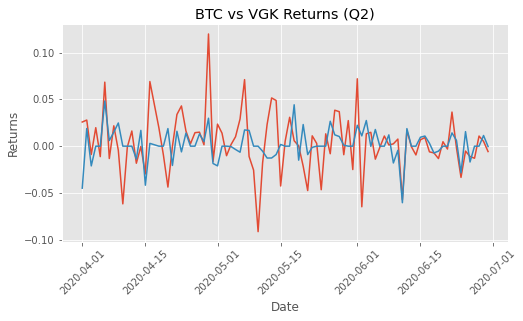

In [8]:
import matplotlib.pyplot as plt

# Change color theme
plt.style.use('ggplot')

# Plot figure
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(q2_returns.index, q2_returns.BTC)
ax.plot(q2_returns.index, q2_returns.VGK)

# Setting the title
ax.set_title("BTC vs VGK Returns (Q2)")

# Setting the ylabels and xlabels
ax.set_ylabel('Returns')
ax.set_xlabel('Date')

# Rotate xticks
plt.xticks(rotation = 45)

plt.show()

#### 4.3 Fit a non-Gaussian copula to the returns of those 2 series.  (Selected Copula: Clayton)

- Selected Quarter: Q2 2020

In [9]:
from copulalib.copulalib import Copula
from array import array 

dataset = q2_returns[q2_returns.VGK != 0] # remove non-trading days for VGK

# Visualise data in scatterplot and histograms
def plotDistributions(x, y):
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(x, bins=20, color='green', alpha=0.8, align='mid')
    plt.title('BTC returns distribution')
    fig.add_subplot(2,2,3)
    plt.scatter(x, y, marker="o", alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint X,Y')
    plt.hist(y, bins=20, orientation='horizontal', color='red', alpha=0.8, align='mid')
    plt.title('VGK returns distribution')    
    plt.show()
    
# Generate Clayton Copula
def plotClaytonCopula(x, y):
    fig = plt.figure()
    clayton = Copula(x, y, family='clayton')
    uc, vc = clayton.generate_uv(500)
    fig.add_subplot(2,2,2)
    plt.scatter(uc,vc,marker='.', s=5, color='red')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Clayton Copula')
    plt.show()

Non-Gaussian Copula of BTC & VGK (Quarter 2)

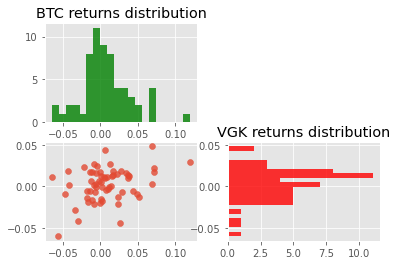

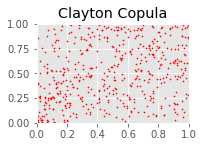

In [10]:
plotDistributions(dataset.BTC, dataset.VGK)
plotClaytonCopula(dataset.BTC, dataset.VGK)

## 6. Category 2 Models

- Use 2 variables: the one you are trading, and an additional (called exogeneous variable) to enhance prediction. <br/>
We continue to use the Bitcoin series and <b>use VGK returns as the exogeneous varaiable</b>.


### 6.1 - 6.2 - 6.3 - 6.4

- (6.1) Use the same series as you did in the previous question<br/>
_(Note: we already know from Section 5 that the input BTC series is stationary. Below, we confirm that VGK series is stationary as well.)_

- (6.2) Use Q2 data for estimation, and Q3 data for evaluating performance.
- (6.3) Repeat, using Q3 data for estimation, and Q4 data for evaluating performance

- (6.4) Build 3 trading strategies<br/>
<b>(Selected strategies: VAR, ARMA-GARCH, Pairs Trading)</b>

In [11]:
# Datasets
q2_returns = get_data(ret_data, 2020, 2020, 4, 7)
q3_returns = get_data(ret_data, 2020, 2020, 7, 10)
q4_returns = get_data(ret_data, 2020, 2021, 10, 1)

cols = ['BTC','VGK']
q4_returns[cols]

,BTC,VGK
Date,,
2020-10-01,-0.015346,0.007789
2020-10-02,-0.003599,-0.000378
2020-10-03,-0.001860,0.000000
2020-10-04,0.011194,0.000000
2020-10-05,0.011129,0.017826
...,...,...
2020-12-27,-0.006251,0.000000
2020-12-28,0.030458,0.006789
2020-12-29,0.010198,0.007235


In [12]:
# Checking VGK series for stationarity (Quarter 2 to Quarter 4)

vgk_returns = get_data(ret_data, 2020, 2021, 4, 1).VGK

p_value_adf = adfuller(vgk_returns)[1]
if p_value_adf < 0.05:
    print("The series of VGK returns is stationary.")
else:
    print("The series of VGK returns is not stationary.")

The series of VGK returns is stationary.


### 6.5 The 1st strategy should include a form of VAR or VARMA.  (Selected model: VAR)

To build the VAR trading strategy, we **fit the VAR model to predict the future returns**. 

The trading strategy works as such: **If the predicted 1-day return is more than zero, we develop a simple long-only trading strategy that buys 1 unit of BTC, holds it for a day and sells it at Market Close the day after.** To evaluate this strategy, we plot the forecasted vs actual returns, and compute the total return for periods Q3 and Q4 (model trained on Q2 and Q3 respectively).

In [13]:
def fit_VAR(dataset):
    var_result = VAR(endog = dataset[cols].values)
    var_lag_selection = var_result.select_order(maxlags=10)
    
    best_lag = var_lag_selection.selected_orders['aic']
    print(f'Best lag value: {best_lag}\n')
    return var_lag_selection.summary(), var_result.fit(best_lag+1)

def rolling_forecast_VAR(var_model, train, predict):
    datapoints = train[cols].values[-1:]
    forecasts = []
    for actual_btc in predict[cols].values:
        forecasts.append(var_model.forecast(datapoints, steps=1)[0][0])
        datapoints = [actual_btc]
    return forecasts

def plot_forecast_vs_actual(result_df, model_name, quarter):
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(result_df.Actual, label = "Actual")
    ax.plot(result_df.Predicted, label = "Predicted")
    ax.legend()
    ax.set_ylabel('BTC Returns')
    plt.title(f"{model_name} - BTC Forecasted vs Actual Returns (Q{quarter})")
    plt.show()
    
def evaluate_strategy(result_df, buy_threshold=0):
    returns = []
    for forecast, actual in result_df.values:
        if forecast > buy_threshold:
            returns.append(actual)
    print("Total Returns: {:.2f}%".format(sum(returns) * 100))
    return np.where(result_df.Predicted > buy_threshold, 1, 0)

#### VAR strategy (Train on Q2, Evaluate on Q3)

In [14]:
# Q2 dataset: Determine best lag value based on AIC

var_selection, var_model = fit_VAR(q2_returns)
var_selection

Best lag value: 0



,AIC,BIC,FPE,HQIC
0,-15.38*,-15.32*,2.098e-07*,-15.35*
1,-15.34,-15.16,2.171e-07,-15.27
2,-15.30,-15.00,2.271e-07,-15.18
3,-15.24,-14.82,2.412e-07,-15.07
4,-15.22,-14.68,2.459e-07,-15.01
5,-15.16,-14.51,2.615e-07,-14.90
6,-15.10,-14.32,2.787e-07,-14.79
7,-15.01,-14.12,3.053e-07,-14.65
8,-14.94,-13.93,3.280e-07,-14.54
9,-14.87,-13.74,3.532e-07,-14.42


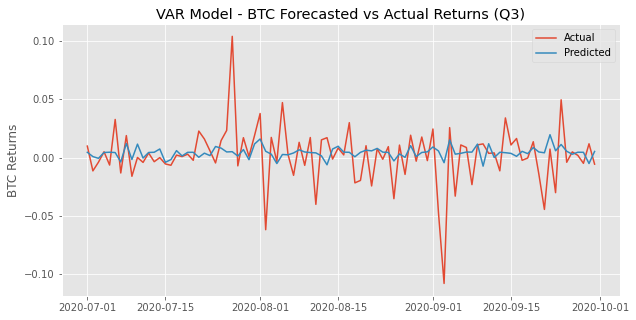

Total Returns: 27.78%
Q3 Long-only Strategy of 92 days (1 for long signal, 0 for no action):


array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1])

In [15]:
forecast_df = pd.DataFrame({
    "Actual": q3_returns.BTC,
    "Predicted": rolling_forecast_VAR(var_model, q2_returns, q3_returns)
}, index = q3_returns.index)

plot_forecast_vs_actual(forecast_df, 'VAR Model', 3)

q3_long_strategy = evaluate_strategy(forecast_df)
print('Q3 Long-only Strategy of', len(q3_returns), "days (1 for long signal, 0 for no action):")
q3_long_strategy

#### VAR strategy (Train on Q3, Evaluate on Q4)

In [16]:
# Q3 dataset: Determine best lag value based on AIC

var_selection, var_model = fit_VAR(q3_returns)
var_selection

Best lag value: 0



,AIC,BIC,FPE,HQIC
0,-16.78*,-16.72*,5.144e-08*,-16.76*
1,-16.77,-16.59,5.228e-08,-16.70
2,-16.72,-16.43,5.485e-08,-16.60
3,-16.62,-16.21,6.034e-08,-16.46
4,-16.59,-16.06,6.238e-08,-16.38
5,-16.55,-15.91,6.489e-08,-16.29
6,-16.49,-15.73,6.906e-08,-16.19
7,-16.41,-15.53,7.524e-08,-16.06
8,-16.33,-15.33,8.203e-08,-15.93
9,-16.28,-15.16,8.674e-08,-15.83


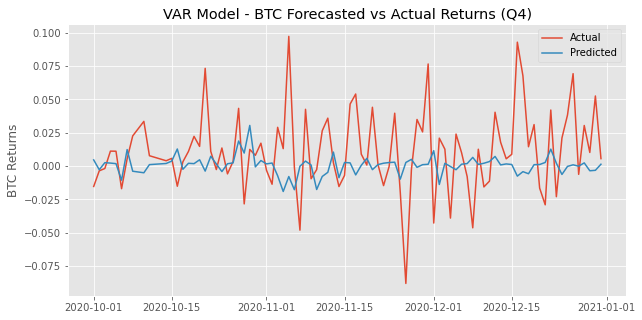

array([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1])

Total Returns: 3.29%
Q4 Long-only Strategy of 89 days (1 for long signal, 0 for no action):


In [17]:
forecast_df = pd.DataFrame({
    "Actual": q4_returns.BTC,
    "Predicted": rolling_forecast_VAR(var_model, q3_returns, q4_returns)
}, index = q4_returns.index)

plot_forecast_vs_actual(forecast_df, 'VAR Model', 4)

q4_long_strategy = evaluate_strategy(forecast_df)
print('Q4 Long-only Strategy of', len(q4_returns), "days (1 for long signal, 0 for no action):")
q4_long_strategy

### 6.6 The 2nd strategy should include multivariate GARCH.  There are several possibilities.  (Selected model: ARMA-GARCH)

To build this trading strategy, we **fit the GARCH model on ARMA residuals** to arrive at the ARMA-GARCH model. 

The trading strategy works as such: **If the predicted 1-day return is more than zero, we develop a simple long-only trading strategy that buys 1 unit of BTC, holds it for a day and sells it at Market Close the day after.** To evaluate this strategy, we plot the forecasted vs actual returns, and compute the total return for periods Q3 and Q4 (model trained on Q2 and Q3 respectively).

In [18]:
def perform_1d_arma_garch_forecast(series, exog): 
    # Best p = 1, best q = 1   - from auto_arima(series, exog=exog, trace=True) 
    arima_model = ARIMA(series, exog=exog, order=(1,0,1)).fit()
    
    # Fit GARCH(1,1) model on the residuals of the ARIMA model
    garch = arch.arch_model(arima_model.resid, vol='GARCH', p=1, q=1).fit(disp="off")
    
    # Use ARIMA to predict mu, GARCH to predict residual
    mu, garch_resid = arima_model.predict(n_periods=1)[0], garch.forecast(horizon=1).mean['h.1'].iloc[-1]
    return mu + garch_resid

def rolling_forecast_arma_garch(train, predict, n=90):
    df = pd.concat([train, predict])[cols]
    return [perform_1d_arma_garch_forecast(df[:date][-1-n:-1].BTC, df[:date][-91:-1].VGK) for date in predict.index]

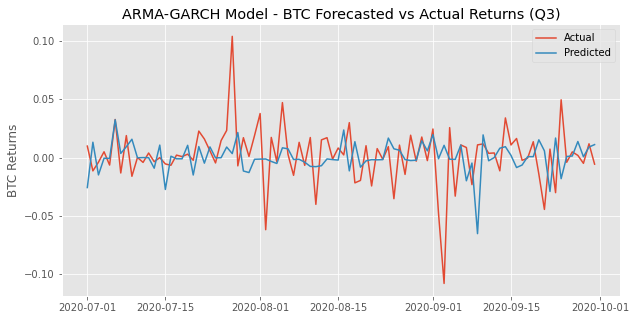

Total Returns: 5.94%
Q3 Long-only Strategy of 92 days (1 for long signal, 0 for no action):


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [19]:
forecast_df = pd.DataFrame({
    "Actual": q3_returns.BTC,
    "Predicted": rolling_forecast_arma_garch(q2_returns, q3_returns)
}, index = q3_returns.index)

plot_forecast_vs_actual(forecast_df, 'ARMA-GARCH Model', 3)
q3_long_strategy = evaluate_strategy(forecast_df, buy_threshold=0.02)
print('Q3 Long-only Strategy of', len(q3_returns), "days (1 for long signal, 0 for no action):")
q3_long_strategy

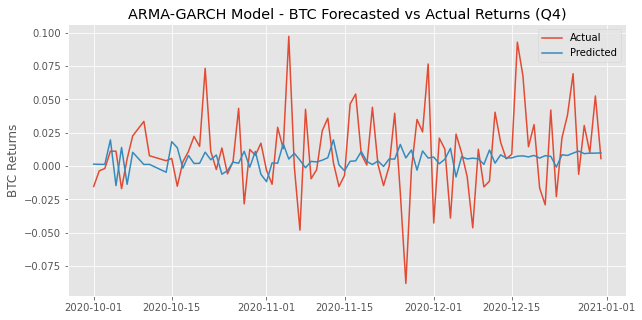

Total Returns: 28.06%
Q4 Long-only Strategy of 89 days (1 for long signal, 0 for no action):


array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1])

In [20]:
forecast_df = pd.DataFrame({
    "Actual": q4_returns.BTC,
    "Predicted": rolling_forecast_arma_garch(q3_returns, q4_returns)
}, index = q4_returns.index)

plot_forecast_vs_actual(forecast_df, 'ARMA-GARCH Model', 4)

q4_long_strategy = evaluate_strategy(forecast_df)
print('Q4 Long-only Strategy of', len(q4_returns), "days (1 for long signal, 0 for no action):")
q4_long_strategy

### 6.7 The 3rd strategy should attempt to include cointegration. (Selected Strategy: Pairs Trading)

Before building this trading strategy, we first establish that **BTC and VGK returns are cointegrated** using the Engle-Granger test, which suggests that this pair has a long-run statistically significant relationship and verifies this necessary assumption of the pairs trading strategy.

The pairs trading strategy leverages on this cointegration relationship in this way: **If the BTC return is negative while VGK return is positive, we develop a simple long-only trading strategy that buys 1 unit of BTC at Market Open the next day and sell it at Market Close the same day.** To evaluate this strategy, we plot the forecasted vs actual returns, and compute the total return for periods Q3 and Q4 (model trained on Q2 and Q3 respectively).

One limitation of this naive approach is that the holding period of each position is only 1 day, which may not be sufficient time for the mean-reversion phenomenon to take place.

In [21]:
def perform_engle_granger(dataset):
    t_coint, p_value, crit_vals = coint(
        y0 = dataset.BTC, y1 = dataset.VGK, trend = "ct", autolag = "aic"
    )
    sig = p_value <= 0.05
    print(f"BTC & VGK are {'' if sig else 'not '}cointegrated. {'p-value = {:,.5f}'.format(p_value)}")
    
q2q4_df = pd.concat([q2_returns, q3_returns, q4_returns])
perform_engle_granger(q2q4_df[cols])

BTC & VGK are cointegrated. p-value = 0.00000


In [22]:
def evaluate_pairs_trading_strategy(returns_df):
    signals = []
    returns = []
    for btc_return, vgk_return in returns_df.values[:-1]:
        if len(signals) > 0 and signals[-1] == 1:
            returns.append(btc_return)
        signals.append(1 if btc_return < 0 and vgk_return > 0 else 0)
    print("Total Returns: {:.2f}%".format(sum(returns) * 100))
    return signals

In [23]:
q3_df = pd.concat([q2_returns, q3_returns]).tail(len(q3_returns)+1)[cols]
q3_strategy = evaluate_pairs_trading_strategy(q3_df)
print(q3_strategy)

Total Returns: -1.20%
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]


In [24]:
q4_df = pd.concat([q3_returns, q4_returns]).tail(len(q4_returns)+1)[cols]
q4_strategy = evaluate_pairs_trading_strategy(q4_df)
print(q4_strategy)

Total Returns: 4.32%
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


### 6.8 Which of the 5 models do you prefer?  Explain your answer in quantitative terms.

Adding up the ROI from each of the 5 models over Q3 and Q4, the winner is the GARCH model.

To expound on the quantitative aspect, we first identify that the pairs trading, while promising, requires a more sophisticated strategy with longer holding period for such a mean-reversion to be effective. For the VAR model, it is unfortunately not comprehensive due to the volatility clustering phenomenon which can lead to unexpected market behavior that defies the assumptions of the model. The best model candidate for this section (in terms of combined ROI as well) is the ARMA-GARCH model, but it pales in comparison to the GARCH model due to a stark difference in key principles: while ARMA GARCH is easily an improvement over ARMA due to the additional training step on residuals, the pure GARCH model directly combats the phenomenon of volatility clustering where returns exhibit a change in variance over time, and this best optimises forecasting performance.

As such, our preference thus far still goes to GARCH.